In [ ]:
import cv2
import torch
from ultralytics import YOLO
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
from torch import nn, optim
from torchvision import models

# Load the YOLOv8 model for human detection
yolo_model = YOLO("yolov8n.pt")  # Load the YOLOv8 model (small version)

# Dataset class to load images and labels from folders
class PETS2009Dataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        
        # Load image paths
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.jpg') or img.endswith('.png')]
        
        # Load corresponding labels for each image
        self.labels = []
        for img_path in self.image_paths:
            label_file = os.path.join(label_folder, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
            if os.path.exists(label_file):
                label = self.load_label(label_file)
                self.labels.append(label)
            else:
                # If label file is missing, handle as needed (e.g., skipping or using default label)
                self.labels.append([0] * 17)  # Example: assume 17 keypoints with zeros
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float32)

    def load_label(self, label_file):
        """
        Function to load labels from a text file. Assuming each label is a series of 
        space-separated floats (x, y coordinates of key points or similar).
        """
        with open(label_file, 'r') as file:
            label = [float(val) for val in file.read().split()]
        return label

# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Folder paths
image_folder = "Time_12-34"  # Folder containing images
label_folder = "labels_folder_time"  # Folder containing labels (with .txt files)

# Initialize the dataset and dataloader
dataset = PETS2009Dataset(image_folder, label_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load the pre-trained ResNet-50 model for pose detection
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 17)  # Adjust for the number of pose keypoints (17 in this case)

# Loss function and optimizer
criterion = nn.MSELoss()  # Using MSE for pose estimation tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to perform human detection with YOLO
def detect_human_with_yolo(image):
    results = yolo_model(image)  # Detect using YOLOv8
    # The result will have a 'boxes' attribute containing the bounding boxes for detected objects
    # Access the boxes, labels, and scores directly from results
    boxes = results[0].boxes.xyxy  # Get bounding box coordinates (x1, y1, x2, y2)
    scores = results[0].boxes.conf  # Get the confidence scores for the predictions
    labels = results[0].boxes.cls  # Get the predicted class labels
    
    # Filter the boxes for humans (class 0 is usually for humans in YOLO)
    human_boxes = []
    for box, score, label in zip(boxes, scores, labels):
        if label == 0:  # Class 0 is usually for humans in YOLO models
            if score > 0.5:  # Optionally, filter based on confidence score
                human_boxes.append(box)  # Append the bounding box of the human

    return human_boxes

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"start Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()

        # Apply YOLO human detection on the input image
        for img in inputs:
            img = transforms.ToPILImage()(img)  # Convert Tensor to PIL image
            human_boxes = detect_human_with_yolo(img)  # Get detected human boxes

            # If human detected, crop the image and feed it into the model
            for box in human_boxes:
                x1, y1, x2, y2 = map(int, box)  # Get coordinates of the bounding box
                cropped_img = img.crop((x1, y1, x2, y2))  # Crop the human from the image

                # Transform the cropped image for model input
                cropped_img = transform(cropped_img).unsqueeze(0)  # Add batch dimension
                
                # Run the cropped image through the model for pose detection
                outputs = model(cropped_img)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# Save the trained model
torch.save(model.state_dict(), "resnet50_pose_detection_with_yolo.pth")


c:\Users\Administrator\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Administrator\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



0: 640x640 (no detections), 54.3ms
Speed: 5.6ms preprocess, 54.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 54.1ms
Speed: 3.7ms preprocess, 54.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 101.1ms
Speed: 3.0ms preprocess, 101.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 53.3ms
Speed: 3.3ms preprocess, 53.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 52.6ms
Speed: 2.8ms preprocess, 52.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 50.9ms
Speed: 3.0ms preprocess, 50.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 49.9ms
Speed: 3.2ms preprocess, 49.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 47.9ms
Speed: 3.3ms preprocess, 47.9ms

c:\Users\Administrator\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 17])) that is different to the input size (torch.Size([1, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0: 640x640 (no detections), 52.3ms
Speed: 3.5ms preprocess, 52.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 79.2ms
Speed: 3.3ms preprocess, 79.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 traffic light, 48.1ms
Speed: 14.0ms preprocess, 48.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 49.5ms
Speed: 3.5ms preprocess, 49.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 49.8ms
Speed: 3.1ms preprocess, 49.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 51.5ms
Speed: 3.2ms preprocess, 51.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 49.3ms
Speed: 3.6ms preprocess, 49.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 car, 52.4ms
Speed: 3.1ms preprocess, 52.4ms inference, 

c:\Users\Administrator\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([27, 17])) that is different to the input size (torch.Size([1, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



0: 640x640 (no detections), 119.3ms
Speed: 4.6ms preprocess, 119.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 122.5ms
Speed: 7.5ms preprocess, 122.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 159.7ms
Speed: 4.1ms preprocess, 159.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 103.1ms
Speed: 7.7ms preprocess, 103.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 125.1ms
Speed: 8.2ms preprocess, 125.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 201.0ms
Speed: 9.4ms preprocess, 201.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 cake, 105.8ms
Speed: 7.6ms preprocess, 105.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
Epoch 5/10, Loss: 0.0048104625940322875

0: 640x640 (no detectio

Predicted Keypoints Shape: (1, 34)
Predicted Keypoints (Raw): [[     1.0477    -0.44874      1.2868     0.23262    -0.12754    -0.92488     0.38253    -0.26754  -0.0031495     0.40387     0.20475    -0.47149     0.13749    0.010979    0.089815     0.02375    0.086201   -0.084956     0.33922    -0.26989    -0.24173     0.28295    -0.34488     0.71631     0.30411    -0.58246
      0.12489    -0.21815    0.063203     -0.1249  -0.0052802    -0.20492     0.18483     0.35305]]


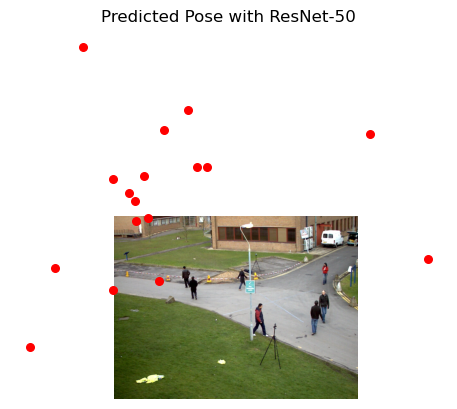

In [16]:
import torch
from PIL import Image
import numpy as np
from torchvision import transforms, models
from matplotlib import pyplot as plt

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the selfie image
selfie_image_path = "frame_0794.jpg"  # Replace with your selfie image path
selfie_image = Image.open(selfie_image_path).convert('RGB')

# Transformation to match input size of ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

input_tensor = transform(selfie_image).unsqueeze(0).to(device)

# Load ResNet-50 model (pose detection)
model = models.resnet50(pretrained=False)

# Modify the final fully connected layer to match the number of keypoints (17 keypoints with 2 coordinates each = 34)
model.fc = torch.nn.Linear(model.fc.in_features, 34)  # 17 keypoints (x, y) = 34 output values

# Load the trained model's state_dict
checkpoint = torch.load("resnet50_pose_detection_with_yolo.pth")

# Remove the `fc` layer from the checkpoint dictionary to avoid mismatching
checkpoint.pop('fc.weight', None)
checkpoint.pop('fc.bias', None)

# Load the state_dict without the `fc` layer
model.load_state_dict(checkpoint, strict=False)

# Move the model to the device (GPU/CPU)
model = model.to(device)
model.eval()

# Run inference to get predicted keypoints
with torch.no_grad():
    predicted_keypoints = model(input_tensor).cpu().numpy()

# Print the shape of the predicted keypoints
print(f"Predicted Keypoints Shape: {predicted_keypoints.shape}")

# Debug: Check what the shape of the output is
print(f"Predicted Keypoints (Raw): {predicted_keypoints}")

# Flatten to (34,) if it's (1, 34)
predicted_keypoints = predicted_keypoints.reshape(-1)  # Now shape will be (34,)

# If the output is a flattened array (34,)
if predicted_keypoints.shape[0] == 34:
    predicted_keypoints = predicted_keypoints.reshape(17, 2)  # Reshape to (17, 2) -> 17 keypoints with (x, y)
elif predicted_keypoints.shape[0] == 17:
    pass  # Already in the correct format (17, 2)
else:
    raise ValueError(f"Unexpected shape of predicted keypoints: {predicted_keypoints.shape}. Expected (34,) or (17, 2).")

# Convert the image to a numpy array for visualization
image_np = np.array(selfie_image)

# Rescale keypoints back to original image size
keypoints_rescaled = predicted_keypoints * np.array([selfie_image.width, selfie_image.height])

# Plot the image
plt.imshow(image_np)
plt.title("Predicted Pose with ResNet-50")
plt.axis('off')

# Plot keypoints
for keypoint in keypoints_rescaled:
    x, y = keypoint
    plt.scatter(x, y, c='r', s=30)  # Plot keypoints in red

plt.show()



0: 480x640 7 persons, 1 car, 2 trucks, 1 bird, 39.9ms
Speed: 1.5ms preprocess, 39.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Predicted Pose Class: 15
Predicted Pose Label: pose_15
<PIL.Image.Image image mode=RGB size=37x111 at 0x20ABAC95190>


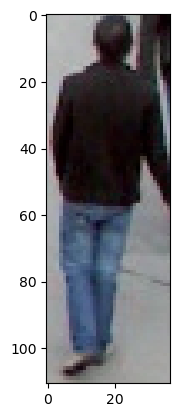

In [20]:
import torch
from PIL import Image
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO

# Load YOLO model
yolo_model = YOLO("yolov8n.pt")

# Load trained ResNet-50 pose classification model (17 pose classes)
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 17)  # Output: 17 classes
model.load_state_dict(torch.load("resnet50_pose_detection_with_yolo.pth"))
model.eval()

# Transform for input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Pose class labels (replace with your actual labels if known)
pose_labels = [f"pose_{i}" for i in range(17)]

def detect_human_with_yolo(image):
    results = yolo_model(image)
    boxes = results[0].boxes.xyxy
    scores = results[0].boxes.conf
    labels = results[0].boxes.cls

    human_boxes = []
    for box, score, label in zip(boxes, scores, labels):
        if label == 0 and score > 0.5:
            human_boxes.append(box)
    return human_boxes

# Load test image
image_path = "frame_0794.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")
human_boxes = detect_human_with_yolo(image)

if human_boxes:
    box = human_boxes[0]
    x1, y1, x2, y2 = map(int, box.tolist())
    cropped_img = image.crop((x1, y1, x2, y2))

    input_tensor = transform(cropped_img).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    predicted_label = pose_labels[predicted_class]
    print(f"Predicted Pose Class: {predicted_class}")
    print(f"Predicted Pose Label: {predicted_label}")

    # Show the cropped image
    plt.imshow(cropped_img)

    print(cropped_img)
else:
    print("No human detected.")


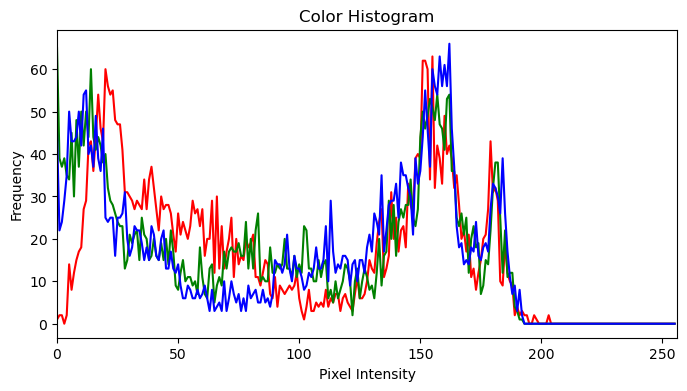

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_color_histogram(img):
    img_np = np.array(img)
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(8, 4))
    for i, color in enumerate(colors):
        hist = cv2.calcHist([img_np], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title("Color Histogram")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

plot_color_histogram(cropped_img)

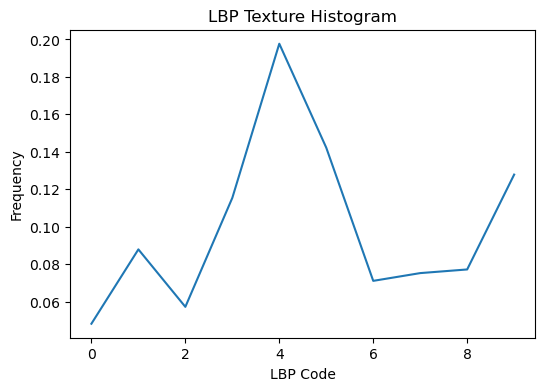

In [22]:
from skimage.feature import local_binary_pattern

def plot_texture_histogram(img):
    gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    radius = 1
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_img, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= hist.sum()

    plt.figure(figsize=(6, 4))
    plt.plot(hist)
    plt.title("LBP Texture Histogram")
    plt.xlabel("LBP Code")
    plt.ylabel("Frequency")
    plt.show()

plot_texture_histogram(cropped_img)
